In [1]:
!pip install -q -U 'tensorflow-text==2.8.*'

     |████████████████████████████████| 4.9 MB 14.9 MB/s 
     |████████████████████████████████| 498.0 MB 12 kB/s 
     |████████████████████████████████| 1.4 MB 67.0 MB/s 
     |████████████████████████████████| 5.8 MB 57.4 MB/s 
     |████████████████████████████████| 462 kB 60.4 MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.3 MB 16.7 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 1.3 MB 42.0 MB/s 
     |████████████████████████████████| 662 kB 49.1 MB/s 
     |████████████████████████████████| 5.8 MB 36.1 MB/s 
     |████████████████████████████████| 118 kB 57.8 MB/s 
     |████████████████████████████████| 352 kB 9.9 MB/s 
     |████████████████████████████████| 588.3 MB 20 kB/s 
     |████████████████████████████████| 1.1 MB 64.5 MB/s 
     |████████████████████████████████| 238 kB 62.5 MB/s 
     |████████████████████████████████| 439 kB 64.9 MB/s 
     |████████████████████████████████| 6.0 MB 49.4 MB/s 
     |████████████████████████████████| 1.7 MB 56.4 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import time
import unicodedata
import datetime
import pathlib
import json

from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers

import tensorflow_hub as hub
import tensorflow_models as tfm

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [5]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

## Parametri BERT

In [6]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  
tfhub_handle_encoder =  'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
gs_folder_bert = 'gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12'
bert_vocab = os.path.join(gs_folder_bert, 'vocab.txt')

print('BERT model selected                : ', tfhub_handle_encoder)
print('Preprocessing model auto-selected  : ', tfhub_handle_preprocess)
print('BERT vocab                         : ', bert_vocab)

BERT model selected                :  https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected  :  https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
BERT vocab                         :  gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12/vocab.txt


### Variabili Globali

In [7]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/BERT/'

# DATI
data_folder_name = 'data'
data_filename = 'dataset_dantesco.csv'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
data_filenamepath = os.path.abspath(os.path.join(DATA_PATH, data_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_bert_dante'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 
log_history = os.path.abspath(os.path.join(PATH_LOG, 'histrory.json'))

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/transformer_bert_dante'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))

# VOCABOLARIO
vocab_folder = 'vocab'
it_vocab_finalname = 'it_vocab_dante.txt'
da_vocab_finalname = 'da_vocab_dante.txt'

VOCAB_PATH = os.path.abspath(os.path.join(root_folder, vocab_folder))
it_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, it_vocab_finalname))
da_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, da_vocab_finalname))

In [16]:
# parametri per il modello
INPUT_COLUMN = 'Translate'
TARGET_COLUMN = 'Original'

# parametri per il modello
NUM_SAMPLES = 46159 
TRAIN = 28000
VALIDATION = 12000
N_VALIDATION = 5
TEST = 159

MAX_VOCAB_SIZE = 20000 
EMBEDDING_DIM = 64 
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
MAX_SEQ_LENGTH = 64

NUM_LAYERS = 1 # Numero di layer di Encoder e Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.5

# Ottimizzatore Adam
LEARNING_RATE_ADAM = 1e-4
BETA_1 = 0.66
BETA_2 = 0.999
EPOCHS_ADAM = 5

# IMPOSTO IL DEBUG A TRUE 
debug = True
training = True

## DATASET

### Caricamento Dati

In [38]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    '''
    Preprocessing dei testi di input, impostando tutti i caratteri
    minuscoli, aggiungendo uno spazio prima di ogni punto e sostituendo
    qualsiasi carattere con uno spazio se non è compreso nel seguente elenco:
    (a-z, A-Z, ".", "?", "!", ",")
    '''
    w = unicode_to_ascii(w.lower().strip())

    # inserimento di uno spazio tra ogni parola e il successivo punto,
    # punto esclamativo, punto interrogativo e virgola
    # esempio: "ciao, come và?" => "ciao , come và ?"
    w = re.sub(r"([?.!,])", r" \1 ", w) # inserimento di uno spazio

    # sostituzione dei caratteri non desiderati con uno spazio
    w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)

    w = re.sub(r'[" "]+', " ", w) # rimozione di più spazi consecutivi
    return w

In [37]:
df = pd.read_csv(
    data_filenamepath,
    sep="\t",
    header=None,
    names=[INPUT_COLUMN, TARGET_COLUMN],
    nrows=NUM_SAMPLES,
    dtype={INPUT_COLUMN: str, TARGET_COLUMN: str}
)

# Preprocessing dei dati di Input
input_data = df[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data = df[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()

train_input_data = input_data[:TRAIN]
train_target_data = target_data[:TRAIN]

validation_input_data = input_data[TRAIN:TRAIN+VALIDATION]
validation_target_data = target_data[TRAIN:TRAIN+VALIDATION]

test_input_data = input_data[TRAIN+VALIDATION:]
test_target_data = target_data[TRAIN+VALIDATION:]

print(f'Dati totali presenti nel Dataset               : {len(df)}')
print(f'Dati totali presenti nel Dataset di Train      : {len(train_input_data)}')
print(f'Dati totali presenti nel Dataset di Validation : {len(validation_input_data)}')
print(f'Dati totali presenti nel Dataset di Train      : {len(test_input_data)}\n')


print('-----------TRAIN SET--------------')
print(train_input_data[-4:])
print(train_target_data[-4:])
print('-----------VALIDATION SET---------------')
print(validation_input_data[-4:])
print(validation_target_data[-4:])
print('-----------TEST SET---------------')
print(test_input_data[-4:])
print(test_target_data[-4:])

TypeError: ignored

### Analisi Dati

In [23]:
print(f'Esempi nel Dataset di Train                            : {len(train_input_data)}')
print(f'Frase più corta in inglese nel Dataset di Train        : {min(train_input_data, key = len)}')
print(f'Frase più corta in italiano nel Dataset di Train       : {min(train_target_data, key = len)}')
print(f'Frase più lunga in inglese nel Dataset di Train        : {max(train_input_data, key = len)}')
print(f'Frase più lunga in italiano nel Dataset di Train       : {max(train_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Validation                       : {len(validation_input_data)}')
print(f'Frase più corta in inglese nel Dataset di Validation   : {min(validation_input_data, key = len)}')
print(f'Frase più corta in italiano nel Dataset di Validation  : {min(validation_target_data, key = len)}')
print(f'Frase più lunga in inglese nel Dataset di Validation   : {max(validation_input_data, key = len)}')
print(f'Frase più lunga in italiano nel Dataset di Validation  : {max(validation_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Test                             : {len(test_input_data)}')
print(f'Frase più corta in inglese nel Dataset di Test         : {min(test_input_data, key = len)}')
print(f'Frase più corta in italiano nel Dataset di Test        : {min(test_target_data, key = len)}')
print(f'Frase più lunga in inglese nel Dataset di Test         : {max(test_input_data, key = len)}')
print(f'Frase più lunga in italiano nel Dataset di Test        : {max(test_target_data, key = len)}')

Esempi nel Dataset di Train                            : 28000


TypeError: ignored

## Tokenizer

Carico il modello di tokenizer di BERT e creo un Tokenizer per il set di dati a disposizione

### Tokenizer Bert

In [ ]:
# Tokenizer BERT
tokenizer_encoder = hub.KerasLayer(tfhub_handle_preprocess, name='Bert_Preprocessing')

### Tokenizer Custom

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)

train_en = dataset.map(lambda en, it: en)
train_it = dataset.map(lambda en, it: it)

bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = MAX_VOCAB_SIZE,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
exist_vocab = Path(en_vocab_filenamepath)

if not exist_vocab.exists():
  en_vocab = bert_vocab.bert_vocab_from_dataset(
      train_en.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(en_vocab_filenamepath, en_vocab)

In [ ]:
exist_vocab = Path(it_vocab_filenamepath)

if not exist_vocab.exists():
  it_vocab = bert_vocab.bert_vocab_from_dataset(
      train_it.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(it_vocab_filenamepath, it_vocab)

In [ ]:
en_tokenizer = text.BertTokenizer(en_vocab_filenamepath, **bert_tokenizer_params)
it_tokenizer = text.BertTokenizer(it_vocab_filenamepath, **bert_tokenizer_params)

In [ ]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  x = tf.concat([starts, ragged, ends], axis=1)
  # x = keras.preprocessing.sequence.pad_sequences(x.numpy(), maxlen=MAX_SEQ_LENGTH, padding='post')
  return x

def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

#### Classe Tokenizer Custom

In [ ]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    
    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()
    
  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [ ]:
tokenizers = tf.Module()
tokenizers.en = CustomTokenizer(reserved_tokens, en_vocab_filenamepath)
tokenizers.it = CustomTokenizer(reserved_tokens, it_vocab_filenamepath)

### Analisi Dati Tokenizzati

In [ ]:
print(f'Vocabolario Italiano : {tokenizers.it.get_vocab_size()}')

Vocabolario Italiano : 2706


In [ ]:
print(input_data[-2:])
print(tokenizer_encoder(input_data[-2:])['input_word_ids'][:, :16])
print('------------------------------------------------------------------')
print(target_data[-2:])
print(tokenizers.it.tokenize(target_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.it.tokenize(target_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post')[:, :16])

['This never happened to me before.', 'What does the Bible say about this?']
tf.Tensor(
[[ 101 2023 2196 3047 2000 2033 2077 1012  102    0    0    0    0    0
     0    0]
 [ 101 2054 2515 1996 6331 2360 2055 2023 1029  102    0    0    0    0
     0    0]], shape=(2, 16), dtype=int32)
------------------------------------------------------------------
['Questo non mi è mai successo in passato.', 'Che cosa dice la Bibbia su questo?']
<tf.RaggedTensor [[2, 76, 53, 68, 28, 97, 231, 61, 462, 11, 3],
 [2, 55, 79, 254, 57, 25, 161, 1952, 236, 76, 23, 3]]>
[[   2   76   53   68   28   97  231   61  462   11    3    0    0    0
     0    0]
 [   2   55   79  254   57   25  161 1952  236   76   23    3    0    0
     0    0]]


In [ ]:
print([min(train_input_data, key = len)])
print(tokenizer_encoder([min(train_input_data, key = len)])['input_word_ids'][:, :16])
print('------------------------------------------------------------------')
print([min(train_target_data, key = len)])
print(tokenizers.en.tokenize([min(train_target_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize([min(train_target_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post')[:, :16])

['How are you? "I can\'t complain."']
tf.Tensor(
[[  101  2129  2024  2017  1029  1000  1045  2064  1005  1056 17612  1012
   1000   102     0     0]], shape=(1, 16), dtype=int32)
------------------------------------------------------------------
['Ti aspetterò.']
<tf.RaggedTensor [[2, 43, 512, 108, 1984, 755, 441, 11, 3]]>
[[   2   43  512  108 1984  755  441   11    3    0    0    0    0    0
     0    0]]


In [ ]:
print([min(train_input_data, key = len)])
print(tokenizer_encoder([max(train_input_data, key = len)])['input_word_ids'][:, :16])
print('------------------------------------------------------------------')
print([max(train_target_data, key = len)])
print(tokenizers.en.tokenize([max(train_target_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize([max(train_target_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post')[:, :40])

['How are you? "I can\'t complain."']
tf.Tensor(
[[ 101 2106 3419 2424 2054 2002 2001 2559 2005 1029  102    0    0    0
     0    0]], shape=(1, 16), dtype=int32)
------------------------------------------------------------------
['Per favore, non fare bollire le uova fino a farle diventare così dure.']
<tf.RaggedTensor [[2, 39, 238, 845, 232, 9, 146, 289, 656, 232, 25, 1976, 571, 1106, 35,
  232, 44, 441, 2106, 359, 29, 779, 441, 24, 656, 471, 27, 616, 665, 629,
  26, 441, 82, 512, 27, 644, 11, 3]]>
[[   2   39  238  845  232    9  146  289  656  232   25 1976  571 1106
    35  232   44  441 2106  359   29  779  441   24  656  471   27  616
   665  629   26  441   82  512   27  644   11    3    0    0]]


## Creazione dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [ ]:
def prepare_batch(en, it):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int64)

  # Tokenizzo l'input per l'Encoder
  encoder = tokenizer_encoder(en)          

  # Tokenizzo l'input per il Decder e creo la variabile Target
  it = tokenizers.it.tokenize(it)
  decoder = it[:, :-1].to_tensor()  # Drop the [END] tokens
  target = it[:, 1:].to_tensor()   # Drop the [START] tokens
  
  decoder = tf.concat([decoder, zero], 1)
  decoder = decoder[:, :(MAX_SEQ_LENGTH)]

  target = tf.concat([target, zero], 1)
  target = target[:, :(MAX_SEQ_LENGTH)]

  return (encoder, decoder), target

In [ ]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
# Suddivido il dataset di validation in n parti per effettuare una validation incrociata
num_record_validation = len(validation_input_data) / N_VALIDATION
val_input_data = []
val_target_data = []

for i in range(N_VALIDATION):
  df_input = validation_input_data[int((i*num_record_validation)):int(((i+1)*num_record_validation))]
  df_target = validation_target_data[int((i*num_record_validation)):int(((i+1)*num_record_validation))]

  val_input_data.append(df_input)
  val_target_data.append(df_target)

In [ ]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
validation_dataset = [tf.data.Dataset.from_tensor_slices((val_input, val_target)) for val_input, val_target in zip(val_input_data, val_target_data)]

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
train_dataset = make_batches(train_dataset)
validation_dataset = [make_batches(val_dataset) for val_dataset in validation_dataset]

In [ ]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (enc_input, dec_input), target in train_dataset.take(1):
  print('----------------------- ENCODER  -------------------------------')
  print(f'Shape                    : {enc_input["input_word_ids"].shape}')
  print(f'Word Ids                 : {enc_input["input_word_ids"][0, :MAX_SEQ_LENGTH]}')
  print(f'Input Mask               : {enc_input["input_mask"][0, :MAX_SEQ_LENGTH]}')
  print(f'Type Ids                 : {enc_input["input_type_ids"][0, :MAX_SEQ_LENGTH]}')  
  print('--------------------- DECODER ----------------------------------')
  print(f'Shape it input           : {dec_input.shape}')
  print(f'Example it input         : {dec_input[0]}')  
  print('--------------------- TARGET -----------------------------------')
  print(f'Shape it input           : {target.shape}')
  print(f'Example it target        : {target[0]}')  

----------------------- ENCODER  -------------------------------
Shape                    : (32, 128)
Word Ids                 : [ 101 3419 5015 1037 2210 9364 1012  102    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Input Mask               : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--------------------- DECODER ----------------------------------
Shape it input           : (32, 64)
Example it input         : [   2   52  497   59  139    8 2368   11    0    0    0    0    0    0
    0    0    0    0    0    0

## Encoder BERT

Predispondo la classe necessaria per la costruzione di BERT


In [ ]:
class EncoderBert(layers.Layer):
  def __init__(self, bert_encoder, embedding_dim, max_len):
    super(EncoderBert, self).__init__()
    self.encoder = hub.KerasLayer(bert_encoder, name='BERT_encoder')
    self.conv_1 = tf.keras.layers.Conv1D(embedding_dim * 4, 1, activation='relu') 
    self.conv_2 = tf.keras.layers.Conv1D(embedding_dim, 1, activation='relu') 
    self.lambda_layer = tf.keras.layers.Lambda(lambda x: x[:,:max_len])
    self.max_len = max_len

  def call(self, x, debug=False):
    # x = self.preprocess(input_sequnces)

    if debug:
      print(f'****************** DEBUG ENCODER BERT ******************')
      print(f"First example")
      print(f'Keys                         : {list(x.keys())}')
      print(f'Shape                        : {x["input_word_ids"].shape}')
      print(f'Word Ids                     : {x["input_word_ids"][0, :self.max_len]}')
      print(f'Input Mask                   : {x["input_mask"][0, :self.max_len]}')
      print(f'Type Ids                     : {x["input_type_ids"][0, :self.max_len]}')
      
    # x = self.encoder(x)['sequence_output'] 
    # encoder_outputs stato intermedio di BERT prima che esegua la traduzione recuperare la metà della lunghezza
    x = self.encoder(x)['encoder_outputs'] 
    x = x[int(len(x) / 2) - 1]

    if debug:
      print()
      print(f'Encoder Outputs BERT Shape   : {x.shape}')
      print(f'Encoder Outputs BERT Values  : {x[0, :1, :self.max_len]}')

    x = self.conv_1(x)
    if debug:
      print()
      print(f'Sequence Conv1 Shape         : {x.shape}')

    x = self.conv_2(x)
    if debug:
      print(f'Sequence Conv2 Shape         : {x.shape}')

    x = self.lambda_layer(x)
    if debug:
      print(f'Sequence Lambda Layer        : {x.shape}')
      print()
      print(f'Sequence Outputs Values      : {x[0, 0, :self.max_len]}')      
      print('*********************************************************') 

    return x

In [ ]:
encoder_bert = EncoderBert(tfhub_handle_encoder, 
                           EMBEDDING_DIM, 
                           MAX_SEQ_LENGTH)

bert_outputs = encoder_bert(enc_input, debug) 

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape                        : (32, 128)
Word Ids                     : [ 101 3419 5015 1037 2210 9364 1012  102    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Input Mask                   : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                     : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[-4.6931457e-02 -5.8503908e-01 -4.5515332e-01 

## Decoder

Predispondo la classe necessaria per la costruzione di un Layer di Decoder

### TOKEN AND POSITION EMBEDDING

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras. 

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [ ]:
token_position_it = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.it.get_vocab_size(), EMBEDDING_DIM)

inputs_decoder = token_position_it(dec_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************


### LAYER DECODER

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

#### DecodeBert

Implmentazione di un blocco di  decodifica custom per decodificare l'output dal layer EncoderBert prima di passarlo al Decoder del Transformer tramite estensione della classe Layer di Keras

In [ ]:
class DecodeBert(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DecodeBert'):
    super(DecodeBert, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self._name = name

  def call(self, bert_outputs, training=False, debug=False):
    attn_output = self.att(query=bert_outputs,
                           value=bert_outputs, 
                           key=bert_outputs)
    
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(bert_outputs + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)

    output = self.layernorm2(out1 + ffn_output)

    if debug:
      print('********************* DEBUG DECODE-BERT *********************')
      print(f'Shape Input Layer Decode-Bert       : {bert_outputs.shape}')
      print(f'Shape Output Layer Decode-Bert      : {output.shape}')
      print('*********************************************************')

    return output

In [ ]:
encoder = DecodeBert(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_encoder = encoder(bert_outputs=bert_outputs,
                          training=training, 
                          debug=debug)

********************* DEBUG DECODE-BERT *********************
Shape Input Layer Decode-Bert       : (32, 64, 64)
Shape Output Layer Decode-Bert      : (32, 64, 64)
*********************************************************


#### Layer Decoder

In [ ]:
class Decoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.decode_bert = DecodeBert(max_len=max_len, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, rate=rate)
    self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.layernorm3 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, bert_outputs, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs, 
                             key=inputs, 
                             use_causal_mask=True)
    
    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    dec_bert = self.decode_bert(bert_outputs=bert_outputs, training=training, debug=debug)

    attn_output2 = self.att2(key=dec_bert, 
                             value=dec_bert, 
                             query=out1)
    
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [ ]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder, 
                          bert_outputs=bert_outputs,  
                          training=training,
                          debug=debug)

********************* DEBUG DECODE-BERT *********************
Shape Input Layer Decode-Bert       : (32, 64, 64)
Shape Output Layer Decode-Bert      : (32, 64, 64)
*********************************************************
******************* DEBUG DECODER ***********************
Input Shape                       : (32, 64, 64)
Shape Outputs Decoder             : (32, 64, 64)
*********************************************************


## TRANSFORMER

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras.

In [ ]:
class TransformerBlock(keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               vocab_size,
               tfhub_handle_encoder,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_dec = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)

    self.encoder = EncoderBert(tfhub_handle_encoder, embed_dim, max_len)
    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.dropout = layers.Dropout(rate)
    self.final_layer = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    encoder_output = self.encoder(inputs_encoder, debug) 

    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_encoder       : {inputs_encoder["input_word_ids"].shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    transformer_output = inputs_decoder
      
    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output, 
                                           bert_outputs=encoder_output, 
                                           training=training,
                                           debug=debug)

    transformer_output = self.dropout(transformer_output)
    logits = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [ ]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.it.get_vocab_size(),
                               tfhub_handle_encoder,
                               DROPUOT)

transformer_output = transformer((enc_input, dec_input), 
                                 training=training,
                                 debug=debug)

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape                        : (32, 128)
Word Ids                     : [ 101 3419 5015 1037 2210 9364 1012  102    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Input Mask                   : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                     : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[-4.6931457e-02 -5.8503908e-01 -4.5515332e-01 

In [ ]:
transformer.summary()

Model: "transformer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 177280    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 encoder_bert_1 (EncoderBert  multiple                 109695553 
 )                                                               
                                                                 
 DEC (Decoder)               multiple                  402912    
                                                                 
 dropout_16 (Dropout)        multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  175890    
                                                 

### Addestramento modello con ottimizzatore ADAM

### Compilazione

In [ ]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ADAM, 
                                       beta_1=BETA_1, 
                                       beta_2=BETA_2),
    metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

# Create a callback Tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Create a callback save the log history
json_logging_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: json_log.write(
        json.dumps({'epoch': epoch, 
                    'loss': logs['loss'],
                    'sparse_categorical_accuracy': logs['sparse_categorical_accuracy'],
                    'val_loss': logs['val_loss'],
                    'val_sparse_categorical_accuracy': logs['val_sparse_categorical_accuracy']}) + '\n'),
    on_train_end=lambda logs: json_log.close()
)

### Addestramento 1

In [ ]:
start = datetime.datetime.now()
EPOCHS_ADAM = 3
initial_epoch = 0
epochs = EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])
  
  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/3
500/500 [==============================] - 558s 1s/step - loss: 4.1907 - sparse_categorical_accuracy: 0.8055 - val_loss: 1.5202 - val_sparse_categorical_accuracy: 0.8411
Epoch 2/3
500/500 [==============================] - 541s 1s/step - loss: 1.2178 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.9227 - val_sparse_categorical_accuracy: 0.8680
Epoch 3/3
500/500 [==============================] - 538s 1s/step - loss: 0.9289 - sparse_categorical_accuracy: 0.8723 - val_loss: 0.8211 - val_sparse_categorical_accuracy: 0.8803
Epoch 4/6
500/500 [==============================] - 545s 1s/step - loss: 0.8413 - sparse_categorical_accuracy: 0.8791 - val_loss: 0.7704 - val_sparse_categorical_accuracy: 0.8843
Epoch 5/6
500/500 [==============================] - 544s 1s/step - loss: 0.7869 - sparse_categorical_accuracy: 0.8840 - val_loss: 0.7279 - val_sparse_categorical_accuracy: 0.8896
Epoch 6/6
500/500 [==============================] - 536s 1s/step - loss: 0.7461 - sparse_categorica

### Addestramento 2

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
EPOCHS_ADAM = 3
initial_epoch = 15
epochs = initial_epoch + EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])

  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 16/18
500/500 [==============================] - 539s 1s/step - loss: 0.5563 - sparse_categorical_accuracy: 0.9035 - val_loss: 0.5229 - val_sparse_categorical_accuracy: 0.9079
Epoch 17/18
500/500 [==============================] - 529s 1s/step - loss: 0.5443 - sparse_categorical_accuracy: 0.9047 - val_loss: 0.5124 - val_sparse_categorical_accuracy: 0.9091
Epoch 18/18
500/500 [==============================] - 528s 1s/step - loss: 0.5344 - sparse_categorical_accuracy: 0.9057 - val_loss: 0.5027 - val_sparse_categorical_accuracy: 0.9100
Epoch 19/21
500/500 [==============================] - 526s 1s/step - loss: 0.5242 - sparse_categorical_accuracy: 0.9066 - val_loss: 0.4965 - val_sparse_categorical_accuracy: 0.9109
Epoch 20/21
500/500 [==============================] - 526s 1s/step - loss: 0.5144 - sparse_categorical_accuracy: 0.9078 - val_loss: 0.4883 - val_sparse_categorical_accuracy: 0.9121
Epoch 21/21
500/500 [==============================] - 526s 1s/step - loss: 0.5058 - spars

### Addestramento 3

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
EPOCHS_ADAM = 4
initial_epoch = 30
epochs = initial_epoch + EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])

  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 31/34
500/500 [==============================] - 538s 1s/step - loss: 0.4368 - sparse_categorical_accuracy: 0.9164 - val_loss: 0.4216 - val_sparse_categorical_accuracy: 0.9205
Epoch 32/34
500/500 [==============================] - 527s 1s/step - loss: 0.4307 - sparse_categorical_accuracy: 0.9169 - val_loss: 0.4166 - val_sparse_categorical_accuracy: 0.9212
Epoch 33/34
500/500 [==============================] - 531s 1s/step - loss: 0.4259 - sparse_categorical_accuracy: 0.9175 - val_loss: 0.4120 - val_sparse_categorical_accuracy: 0.9224
Epoch 34/34
500/500 [==============================] - 531s 1s/step - loss: 0.4214 - sparse_categorical_accuracy: 0.9180 - val_loss: 0.4117 - val_sparse_categorical_accuracy: 0.9229
Epoch 35/38
500/500 [==============================] - 524s 1s/step - loss: 0.4157 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.4086 - val_sparse_categorical_accuracy: 0.9231
Epoch 36/38
500/500 [==============================] - 524s 1s/step - loss: 0.4118 - spars

### Addestramento 4

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
EPOCHS_ADAM = 4
initial_epoch = 50
epochs = initial_epoch + EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])

  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 51/54
500/500 [==============================] - 542s 1s/step - loss: 0.3553 - sparse_categorical_accuracy: 0.9267 - val_loss: 0.3662 - val_sparse_categorical_accuracy: 0.9315
Epoch 52/54
500/500 [==============================] - 532s 1s/step - loss: 0.3523 - sparse_categorical_accuracy: 0.9272 - val_loss: 0.3640 - val_sparse_categorical_accuracy: 0.9315
Epoch 53/54
500/500 [==============================] - 531s 1s/step - loss: 0.3496 - sparse_categorical_accuracy: 0.9276 - val_loss: 0.3634 - val_sparse_categorical_accuracy: 0.9316
Epoch 54/54
500/500 [==============================] - 535s 1s/step - loss: 0.3472 - sparse_categorical_accuracy: 0.9278 - val_loss: 0.3598 - val_sparse_categorical_accuracy: 0.9325
Epoch 55/58
500/500 [==============================] - 533s 1s/step - loss: 0.3433 - sparse_categorical_accuracy: 0.9286 - val_loss: 0.3589 - val_sparse_categorical_accuracy: 0.9331
Epoch 56/58
500/500 [==============================] - 532s 1s/step - loss: 0.3413 - spars

### Addestramento 5

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
EPOCHS_ADAM = 4
initial_epoch = 70
epochs = initial_epoch + EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])

  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 71/74
500/500 [==============================] - 543s 1s/step - loss: 0.3073 - sparse_categorical_accuracy: 0.9338 - val_loss: 0.3438 - val_sparse_categorical_accuracy: 0.9372
Epoch 72/74
500/500 [==============================] - 528s 1s/step - loss: 0.3048 - sparse_categorical_accuracy: 0.9340 - val_loss: 0.3426 - val_sparse_categorical_accuracy: 0.9375
Epoch 73/74
500/500 [==============================] - 528s 1s/step - loss: 0.3028 - sparse_categorical_accuracy: 0.9344 - val_loss: 0.3439 - val_sparse_categorical_accuracy: 0.9377
Epoch 74/74
500/500 [==============================] - 521s 1s/step - loss: 0.3017 - sparse_categorical_accuracy: 0.9345 - val_loss: 0.3434 - val_sparse_categorical_accuracy: 0.9382
Epoch 75/78
500/500 [==============================] - 523s 1s/step - loss: 0.2999 - sparse_categorical_accuracy: 0.9348 - val_loss: 0.3400 - val_sparse_categorical_accuracy: 0.9384
Epoch 76/78
500/500 [==============================] - 521s 1s/step - loss: 0.2983 - spars

### Addestramento 6

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
EPOCHS_ADAM = 4
initial_epoch = 90
epochs = initial_epoch + EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])

  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 91/94
500/500 [==============================] - 532s 1s/step - loss: 0.2787 - sparse_categorical_accuracy: 0.9379 - val_loss: 0.3400 - val_sparse_categorical_accuracy: 0.9406
Epoch 92/94
500/500 [==============================] - 528s 1s/step - loss: 0.2772 - sparse_categorical_accuracy: 0.9382 - val_loss: 0.3364 - val_sparse_categorical_accuracy: 0.9406
Epoch 93/94
500/500 [==============================] - 520s 1s/step - loss: 0.2755 - sparse_categorical_accuracy: 0.9385 - val_loss: 0.3369 - val_sparse_categorical_accuracy: 0.9408
Epoch 94/94
500/500 [==============================] - 528s 1s/step - loss: 0.2746 - sparse_categorical_accuracy: 0.9387 - val_loss: 0.3363 - val_sparse_categorical_accuracy: 0.9409
Epoch 95/98
500/500 [==============================] - 528s 1s/step - loss: 0.2734 - sparse_categorical_accuracy: 0.9388 - val_loss: 0.3361 - val_sparse_categorical_accuracy: 0.9415
Epoch 96/98
500/500 [==============================] - 524s 1s/step - loss: 0.2726 - spars

### Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

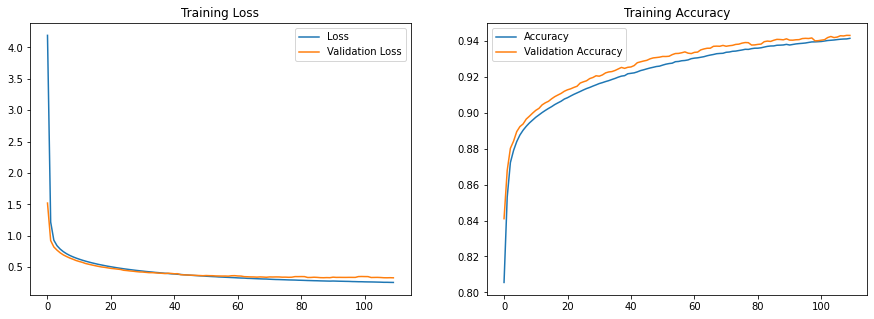

In [ ]:
# Recupero il log di addestramento
df_history = pd.read_json(log_history, lines=True)

# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(df_history['loss'], label='Loss')
ax1.plot(df_history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(df_history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(df_history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

### Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
class Translate:
  def __init__(self, transformer_block, tokenizers, tokenizer_bert):
    self.transformer = transformer_block
    self.tokenizers = tokenizers
    self.tokenizer_bert = tokenizer_bert

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = input_data[np.random.choice(len(input_data))]
      print(input_text)

    inputs_bert = self.tokenizer_bert(input_text)

    start_end = self.tokenizers.it.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int64, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, start)     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())
      
      transformer_output = transformer([inputs_bert, output], 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (K.argmax(transformer_output, axis=-1)).numpy()
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])

      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.it.detokenize(output)[0]  

    tokens = tokenizers.it.lookup(output)[0]

    return text, tokens

In [ ]:
test_sequences = [test_input_data[1], test_input_data[33], test_input_data[10], 
                  test_input_data[57], test_input_data[62], test_input_data[15], 
                  test_input_data[4], test_input_data[42]]

translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers,
                      tokenizer_bert=tokenizer_encoder)

for test_sequence in test_sequences:
  text, token = translate.predict(tf.constant([test_sequence]), MAX_SEQ_LENGTH)

  print(f'{"Input:":15s}: {test_sequence}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  # print(f'tokens : {token}')
  # print(target_data[41])
  # break
  print('---------------------------------------------')

print(test_target_data[1])
print(test_target_data[33])
print(test_target_data[10])
print(test_target_data[57])
print(test_target_data[62])
print(test_target_data[15])
print(test_target_data[4])
print(test_target_data[42])

Input:         : Tom didn't say when he would return.
Prediction     : tom non ha detto quando si e stato .
---------------------------------------------
Input:         : It could just be your imagination.
Prediction     : potrebbe essere solo la sua immaginazione .
---------------------------------------------
Input:         : After dinner, I walk on the beach.
Prediction     : dopo cena soffformante nel frigo .
---------------------------------------------
Input:         : Aren't you busy tomorrow afternoon?
Prediction     : non sei occupato domani pomeriggio ?
---------------------------------------------
Input:         : I don't think we should stay here.
Prediction     : non penso che dovremmo tornare qui .
---------------------------------------------
Input:         : Who told you Tom wouldn't do that?
Prediction     : chi ti ha detto che tom non lo avrebbe fatto ?
---------------------------------------------
Input:         : Reading books will make you smarter.
Prediction     :

### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir

In [ ]:
%tensorboard --logdir drive/MyDrive/BERT/logs/fit/20221026-134720